# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [1]:
#!pip install pycrf
#!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

In [2]:
import pandas as pd
import numpy as np
import os
import re
from tqdm import tqdm

In [3]:
import requests
from nltk import FreqDist
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

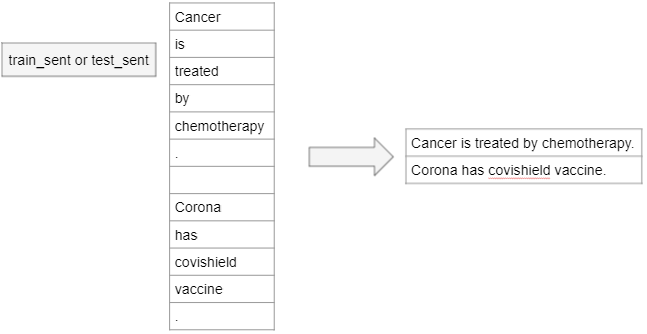

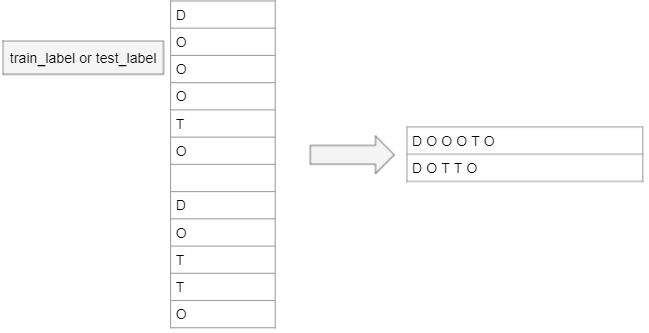

In [4]:
con_train = open("train_sent", 'r', encoding="utf-8")
train_sent_dataset=con_train.read()
con_train.close()

con_train_label = open("train_label", 'r', encoding="utf-8")
train_label_dataset=con_train_label.read()
con_train_label.close()

con_test = open("test_sent", 'r', encoding="utf-8")
test_sent_dataset = con_test.read()
con_test.close()

con_test_label = open("test_label", 'r', encoding="utf-8")
test_label_dataset = con_test_label.read()
con_test_label.close()

In [5]:
print(train_sent_dataset[:500])

All
live
births
>
or
=
23
weeks
at
the
University
of
Vermont
in
1995
(
n
=
2395
)
were
retrospectively
analyzed
for
delivery
route
,
indication
for
cesarean
,
gestational
age
,
parity
,
and
practice
group
(
to
reflect
risk
status
)

The
total
cesarean
rate
was
14.4
%
(
344
of
2395
)
,
and
the
primary
rate
was
11.4
%
(
244
of
2144
)

Abnormal
presentation
was
the
most
common
indication
(
25.6
%
,
88
of
344
)

The
``
corrected
''
cesarean
rate
(
maternal-fetal
medicine
and
transported
patients
exc


In [6]:
train_sent = train_sent_dataset[:500].split("\n")

In [7]:
print(train_sent)

['All', 'live', 'births', '>', 'or', '=', '23', 'weeks', 'at', 'the', 'University', 'of', 'Vermont', 'in', '1995', '(', 'n', '=', '2395', ')', 'were', 'retrospectively', 'analyzed', 'for', 'delivery', 'route', ',', 'indication', 'for', 'cesarean', ',', 'gestational', 'age', ',', 'parity', ',', 'and', 'practice', 'group', '(', 'to', 'reflect', 'risk', 'status', ')', '', 'The', 'total', 'cesarean', 'rate', 'was', '14.4', '%', '(', '344', 'of', '2395', ')', ',', 'and', 'the', 'primary', 'rate', 'was', '11.4', '%', '(', '244', 'of', '2144', ')', '', 'Abnormal', 'presentation', 'was', 'the', 'most', 'common', 'indication', '(', '25.6', '%', ',', '88', 'of', '344', ')', '', 'The', '``', 'corrected', "''", 'cesarean', 'rate', '(', 'maternal-fetal', 'medicine', 'and', 'transported', 'patients', 'exc']


In [8]:
train_sent = " ".join(train_sent)

In [9]:
print(train_sent)

All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )  The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )  Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )  The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients exc


In [10]:
train_sent = re.split(r"\s\s", train_sent)

In [11]:
print(train_sent)

['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )', 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )', 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )', "The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients exc"]


In [12]:
print(train_sent[1])

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


In [13]:
def makeSentence(dataset):
    dataset = dataset.split("\n")
    dataset = " ".join(dataset)
    dataset = re.split(r"\s\s", dataset)
    
    return dataset

In [14]:
#df_train = pd.DataFrame({'train_sent':train_sent,'train_label':train_label})
#df_test = pd.DataFrame({'train_sent':test_sent,'train_label':test_label})

In [15]:
train_sent = makeSentence(train_sent_dataset)
train_label = makeSentence(train_label_dataset)
test_sent = makeSentence(test_sent_dataset)
test_label = makeSentence(test_label_dataset)

In [16]:
print(train_sent[0])
#print(train_label[0])
#print(test_sent[0])
#print(test_label[0])

All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )


### Count the number of sentences in the processed train and test dataset 

In [17]:
print(len(train_sent))
print(len(test_sent))

2600
1057


### Count the number of lines of labels in the processed train and test dataset.

In [18]:
print(len(train_label))
print(len(test_label))

2600
1057


In [19]:
print((train_sent[2]))
print((train_label[2]))

Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
O O O O O O O O O O O O O O O


In [20]:
print((train_sent[15]))
print((train_label[15]))

All patients were managed by an intensified protocol , including stringent glycemic control
O O O O O O O O O O O T T


##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [21]:
sent = model(train_sent[15])
for tok in sent:
    print(tok.text,"---",tok.lemma_,"---",tok.pos_)

All --- all --- DET
patients --- patient --- NOUN
were --- be --- AUX
managed --- manage --- VERB
by --- by --- ADP
an --- an --- DET
intensified --- intensify --- VERB
protocol --- protocol --- NOUN
, --- , --- PUNCT
including --- include --- VERB
stringent --- stringent --- ADJ
glycemic --- glycemic --- ADJ
control --- control --- NOUN


for sent in train_sent:
    sent = model(sent)
    for tok in sent:
        print(tok.text,"---",tok.lemma_,"---",tok.pos_)

In [22]:
def CreateDf_Text_Pos(dataset):
    from tqdm import tqdm
    pos = []
    lemma = []
    text = []
    for sent in dataset:
        sent = model(sent)
        for tok in sent:
            pos.append(tok.pos_)
            lemma.append(tok.lemma_)
            text.append(tok.text)
    df = pd.DataFrame({'text':text,'lemma':lemma,'pos':pos})
    return df

In [23]:
df_train_sent = CreateDf_Text_Pos(train_sent)

In [24]:
df_train_sent.head(10)

,text,lemma,pos
0,All,all,DET
1,live,live,ADJ
2,births,birth,NOUN
3,>,>,X
4,or,or,CCONJ
5,=,=,SYM
6,23,23,NUM
7,weeks,week,NOUN
8,at,at,ADP
9,the,the,DET


In [25]:
df_train_sent_NOUN = df_train_sent.loc[(df_train_sent['pos'] == 'NOUN') | (df_train_sent['pos'] == 'PROPN')]
df_train_sent_NOUN.head(10)

,text,lemma,pos
2,births,birth,NOUN
7,weeks,week,NOUN
10,University,University,PROPN
12,Vermont,Vermont,PROPN
16,n,n,NOUN
24,delivery,delivery,NOUN
25,route,route,NOUN
27,indication,indication,NOUN
29,cesarean,cesarean,PROPN
32,age,age,NOUN


In [26]:
df_train_sent_NOUN[(df_train_sent_NOUN['pos']=='NOUN') | (df_train_sent_NOUN['pos'] == 'PROPN')]['lemma'].value_counts()

patient                412
treatment              214
%                      161
study                  152
cancer                 150
                      ... 
aldosterone              1
sulfobromophthalein      1
BSP                      1
bsp                      1
osteoarthritis           1
Name: lemma, Length: 4717, dtype: int64

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [27]:
def plot_word_frequency(words, top_n=10):
    word_freq = FreqDist(words)
    labels = [element[0] for element in word_freq.most_common(top_n)]
    counts = [element[1] for element in word_freq.most_common(top_n)]
    
    plt.figure(num=None, figsize=(20, 12), dpi=80, facecolor='w', edgecolor='k')
    plot = sns.barplot(labels, counts)
    
    return plot

E:\Anaconda\envs\tensorflowEnv2.6\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

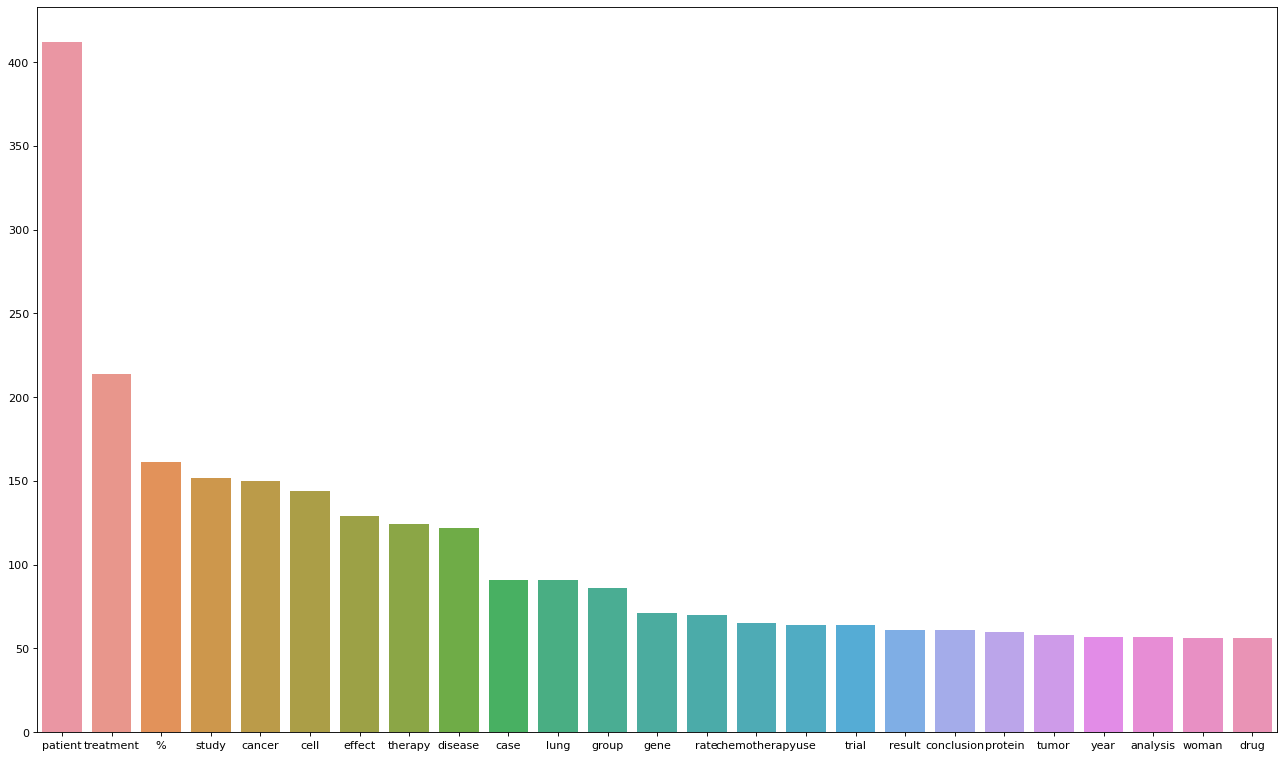

In [28]:
plot_word_frequency(df_train_sent_NOUN.lemma.tolist(), 25)

## Defining features for CRF





In [29]:
# Let's define the features to get the feature value for one word.
def getFeaturesForOneWord(sentence, pos):
    word = sentence[pos]
    
    features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'words.startsWithCapital=%s' % word[0].isupper() # is the word starting with a capital letter
    ]

    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(), 
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_words.startsWithCapital=%s' % prev_word[0].isupper()
      ])
    else:
        features.append('BEG') # feature to track begin of sentence 

    if(pos == len(sentence)-1):
        features.append('END') # feature to track end of sentence

    return features

In [30]:
# Define a function to get features for a sentence 
# using the 'getFeaturesForOneWord' function.
def getFeaturesForOneSentence(sentence):
    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]

## Getting the features

### Write a code/function to get the features for a sentence

In [31]:
train_sent[15]

'All patients were managed by an intensified protocol , including stringent glycemic control'

In [32]:
# Write a code to get features for a sentence.
example_sentence = train_sent[15]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[11]

All patients were managed by an intensified protocol , including stringent glycemic control


['word.lower=glycemic',
 'word[-3:]=mic',
 'word[-2:]=ic',
 'word.isupper=False',
 'word.isdigit=False',
 'words.startsWithCapital=False',
 'prev_word.lower=stringent',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_words.startsWithCapital=False']

### Write a code/function to get the labels of a sentence

In [33]:
# Define a function to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

In [34]:
# Write a code to get the labels for a sentence.
labels = getLabelsInListForOneSentence(train_label[15])
labels

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'T', 'T']

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [35]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sent]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent]

### Define the labels as the target variable for test and the train dataset

In [36]:
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_label]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_label]

## Build the CRF Model

In [37]:
# Build the CRF model.
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)
crf.fit(X_train, Y_train)

E:\Anaconda\envs\tensorflowEnv2.6\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(keep_tempfiles=None, max_iterations=100)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [38]:
# Calculate the f1 score using the test data
Y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [39]:
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9020506167884227

In [40]:
# Print the orginal labels and predicted labels for the sentence  in test data, which is at index value 10.
id = 46
print("Sentence:",test_sent[id])
print("Orig Labels:", Y_test[id])
print("Pred Labels:", Y_pred[id])

Sentence: < TO_SEE > CONTEXT : There is a substantial risk of a second cancer for persons with hereditary retinoblastoma , which is enhanced by radiotherapy
Orig Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'D', 'O', 'O', 'O', 'O', 'O', 'T']


In [41]:
len(test_sent[5].split(" "))

29

In [42]:
print(len(test_sent[5].split(" ")))
print(len(Y_test[5]))
print(len(Y_pred[5]))

29
29
29


In [43]:
print(len(test_sent))
print(len(Y_test))
print(len(Y_pred))

1057
1057
1057


##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

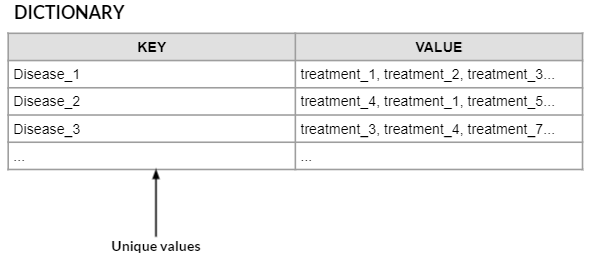

In [167]:
final_df = pd.DataFrame({'test_sent':test_sent, 'Y_test':Y_test, 'Y_pred':Y_pred})
final_df.head(10)

,test_sent,Y_test,Y_pred
0,"Furthermore , when all deliveries were analyze...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,"As the ambient temperature increases , there i...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,The daily high temperature ranged from 71 to 1...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,There was a significant correlation between th...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,Fluctuations in ambient temperature are invers...,"[O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O]"
5,This study tested the hypothesis that to reduc...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, D, ..."
6,"In the `` early '' and `` late '' groups , mea...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
7,The rate of macrosomic and large-for-gestation...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
8,"In our study , we specifically analyzed the ro...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
9,"All together , 27 fetuses had this disorder , ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [168]:
for ind in final_df.test_sent.index:
    final_df.test_sent[ind] = final_df.test_sent[ind].split(" ")

In [169]:
final_df.Y_pred.tolist()[46]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'D',
 'D',
 'O',
 'O',
 'O',
 'O',
 'O',
 'T']

In [170]:
test_sent_list = final_df.test_sent.tolist()
Y_test_list = final_df.Y_test.tolist()
Y_pred_list = final_df.Y_pred.tolist()

In [171]:
Y_pred_list

[['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',


In [172]:
print(len(test_sent_list))
print(len(Y_test_list))
print(len(Y_pred_list))

1057
1057
1057


In [173]:
disease_list = []

for sent_ind, sent in enumerate(Y_pred_list):
    dum_list = []
    for tok_ind, tok in enumerate(sent):
        if tok == 'D':
            dum_list.append(test_sent_list[sent_ind][tok_ind])
            #print(test_sent_list[sent_ind][tok_ind])
            #dum = (test_sent_list[sent_ind][tok_ind])
            #disease_list.append(dum)
    disease_list.append(dum_list)

In [174]:
treatment_list = []

for sent_ind, sent in enumerate(Y_pred_list):
    dum_list = []
    for tok_ind, tok in enumerate(sent):
        if tok == 'T':
            dum_list.append(test_sent_list[sent_ind][tok_ind])
            #print(test_sent_list[sent_ind][tok_ind])
            #dum = (test_sent_list[sent_ind][tok_ind])
            #disease_list.append(dum)
    treatment_list.append(dum_list)

In [175]:
print(len(disease_list))
print(len(treatment_list))

1057
1057


In [176]:
disease_list

[[],
 [],
 [],
 [],
 [],
 ['gestational', 'diabetes', 'cases'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['preeclampsia'],
 [],
 ['severe', 'preeclampsia'],
 [],
 [],
 [],
 [],
 ['asymmetric', 'double', 'hemiplegia'],
 ['reversible', 'nonimmune', 'hydrops', 'fetalis'],
 [],
 [],
 [],
 [],
 [],
 ['breast', 'and/or', 'ovarian', 'cancer'],
 [],
 ['breast', 'cancer', 'breast', 'cancer', 'ovarian', 'cancer'],
 [],
 [],
 [],
 ['prostate', 'cancer', 'mutated', 'prostate', 'cancer'],
 [],
 [],
 ['hereditary', 'prostate', 'cancer'],
 ['prostate', 'cancer'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['hereditary', 'retinoblastoma'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['epilepsy'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['unstable', 'angina', 'or', 'non-Q-wave', 'myocardial', 'infarction'],
 [],
 ['coronary-artery', 'disease'],
 [],
 ['early-stage', 'cervical', 'carcinoma'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['advanced', 'diseas

In [177]:
for ind, ele in enumerate(disease_list):
    disease_list[ind] = " ".join(ele)
    
for ind, ele in enumerate(treatment_list):
    treatment_list[ind] = " ".join(ele)

In [178]:
disease_list

['',
 '',
 '',
 '',
 '',
 'gestational diabetes cases',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'preeclampsia',
 '',
 'severe preeclampsia',
 '',
 '',
 '',
 '',
 'asymmetric double hemiplegia',
 'reversible nonimmune hydrops fetalis',
 '',
 '',
 '',
 '',
 '',
 'breast and/or ovarian cancer',
 '',
 'breast cancer breast cancer ovarian cancer',
 '',
 '',
 '',
 'prostate cancer mutated prostate cancer',
 '',
 '',
 'hereditary prostate cancer',
 'prostate cancer',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'hereditary retinoblastoma',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'epilepsy',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'unstable angina or non-Q-wave myocardial infarction',
 '',
 'coronary-artery disease',
 '',
 'early-stage cervical carcinoma',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'advanced disease',
 '',
 '',
 '',
 '',
 'cerebral palsy',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'severe pain',
 '',
 'myofascial trigger point

In [179]:
treatment_list

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'radiotherapy',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'warfarin with 80 mg aspirin , or 1 mg warfarin with 80 mg aspirin',
 '1 mg warfarin with 80 mg aspirin',
 '',
 'roxithromycin',
 '',
 '',
 '',
 '',
 '',
 '',
 'therapy',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'electrical nerve stimulation ( ENS ) therapy',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'surgical correction',
 'dexfenfluramine hydrochloride',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'G-

In [180]:
Disease_treatment_df = pd.DataFrame({'Disease':disease_list, 'Treatment':treatment_list})
Disease_treatment_df.head(10)

,Disease,Treatment
0,,
1,,
2,,
3,,
4,,
5,gestational diabetes cases,
6,,
7,,
8,,
9,,


In [181]:
Disease_treatment_df = Disease_treatment_df[(Disease_treatment_df['Disease'].str.len() != 0) & (Disease_treatment_df['Treatment'].str.len() != 0)]
Disease_treatment_df = Disease_treatment_df.reset_index(drop=True)
Disease_treatment_df

,Disease,Treatment
0,hereditary retinoblastoma,radiotherapy
1,unstable angina or non-Q-wave myocardial infar...,roxithromycin
2,cellulitis,G-CSF therapy intravenous antibiotic treatment
3,early Parkinson 's disease,Ropinirole monotherapy
4,female stress urinary incontinence,surgical treatment
...,...,...
88,severe secondary peritonitis,Surgical management
89,hepatic metastases from colorectal cancer,Hepatic arterial infusion of chemotherapy afte...
90,Poliomyelitis prevention,live oral poliovirus vaccines
91,chronic renal failure,Epoetin


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [185]:
Disease_treatment_df[(Disease_treatment_df['Disease']=='hereditary retinoblastoma')]['Treatment']

0    radiotherapy
Name: Treatment, dtype: object

#### From the above dataframe, we can say that the treatment for 'hereditary retinoblastoma' is 'radiotherapy'

In [182]:
from util import print_top_likely_transitions
from util import print_top_unlikely_transitions

In [183]:
print_top_likely_transitions(crf.transition_features_)

D      -> D       4.202874
T      -> T       3.974368
O      -> O       1.145710
O      -> D       1.102061
T      -> O       0.703825
D      -> O       -1.118125
O      -> T       -1.345239
D      -> T       -2.747252


In [184]:
print_top_unlikely_transitions(crf.transition_features_)

D      -> D       4.202874
T      -> T       3.974368
O      -> O       1.145710
O      -> D       1.102061
T      -> O       0.703825
D      -> O       -1.118125
O      -> T       -1.345239
D      -> T       -2.747252
